### Load data

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from numba import njit, prange

from matplotlib import pyplot as plt

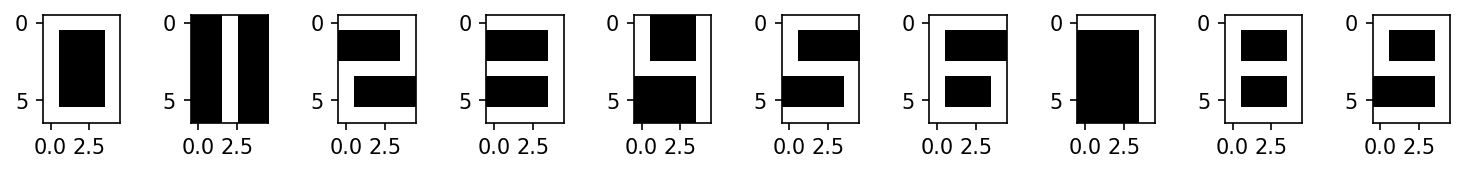

In [2]:
fig, axes = plt.subplots(nrows=1, ncols=10)

fig.set_dpi(150)
fig.set_figwidth(10)
fig.set_figheight(5)

nums_mtrx =  np.loadtxt(Path(r'D:/Development/Data/datasets/txt/numbers_7x5.txt'))

for n, ax in zip(nums_mtrx, axes.ravel()):
    ax.imshow(n.reshape(7, 5), cmap='binary_r')

plt.tight_layout()
plt.show()

### Generate dataset

In [20]:
np.random.seed(0)

cells_columns = [f'c{n}' for n in range(35)]
classes = ['zero','one','two','three','four','five','six','seven','eight','nine']

df = pd.DataFrame(columns=cells_columns+['class'])

for i in range(10):
    new_row = dict(zip(cells_columns, nums_mtrx[i]))
    new_row['class'] = classes[i]
    
    df.loc[df.index.size] = new_row

    for j in range(9):
        noised_num = nums_mtrx[i] + np.random.uniform(0, 0.25, 35)
        
        new_row = dict(zip(cells_columns, noised_num))
        new_row['class'] = classes[i]
        
        df.loc[df.index.size] = new_row

for name in df['class'].unique():
    df[f'{name}_label'] = df['class'].map(lambda x: 1 if x == name else 0)

### Split dataset to test and train

In [21]:
test_frac = 0.2

p = np.arange(10)

test_size = int(p.size * test_frac)
train_size = int(p.size * (1 - test_frac))

idx_test = np.ravel([(p[0:test_size] + i * 10) for i in range(10)])
idx_train = np.ravel([(p[test_size:p.size] + i * 10) for i in range(10)])

features_columns = cells_columns
label_columns = [f"{name}_label" for name in classes]

x_test = np.array(df.iloc[idx_test][features_columns])
y_test = np.array(df.iloc[idx_test][label_columns])

x_tarin = np.array(df.iloc[idx_train][features_columns])
y_train = np.array(df.iloc[idx_train][label_columns])

### Define activation functions

In [12]:
@njit(fastmath=True)
def ReLU(x: np.ndarray, p: np.ndarray, q: np.ndarray) -> np.ndarray:
    return p * x * (x >= 0) + q * x * (x < 0)

@njit(fastmath=True)
def dReLU(x: np.ndarray, p: np.ndarray, q: np.ndarray) -> np.ndarray:
    return p * (x >= 0) + q * (x < 0)

@njit(fastmath=True)
def dReLU_dp(x: np.ndarray) -> np.ndarray:
    return x * (x >= 0)

@njit(fastmath=True)
def dReLU_dq(x: np.ndarray) -> np.ndarray:
    return x * (x < 0)

@njit(fastmath=True)
def softmax(x: np.ndarray) -> np.ndarray:
    y = np.exp(x)
    return y / np.sum(y)

### Define model

In [13]:
@njit(fastmath=True)
def grads(x_batch: np.ndarray, y_batch: np.ndarray, V: np.ndarray, W: np.ndarray, c: np.ndarray, b: np.ndarray, p: np.ndarray, q: np.ndarray) -> tuple[np.ndarray]:
    dV = np.zeros(V.shape)
    dc = np.zeros(c.shape)

    dW = np.zeros(W.shape)
    db = np.zeros(b.shape)

    dp = np.zeros(p.shape)
    dq = np.zeros(q.shape)
    
    for i in prange(x_batch.shape[0]):
        u = V @ x_batch[i] + c
        h = ReLU(u, p, q)
        y = softmax(W @ h + b)

        dLdh = W.T @ (y - y_batch[i])
        
        dV += np.outer(dLdh * dReLU(u, p, q), x_batch[i])
        dc += dLdh * dReLU(u, p, q)

        dW += np.outer(y - y_batch[i], h)
        db += y - y_batch[i]

        dp += dLdh * dReLU_dp(u)
        dq += dLdh * dReLU_dq(u)
        
    return (dV, dW, dc, db, dp, dq)

class Perceptron:
    def __init__(self, nIn: int, nH: int, nOut: int) -> None:
        self.nIn = nIn
        self.nH = nH
        self.nOut = nOut
        
        self.V: np.ndarray = np.random.uniform(-1, 1, (nH, nIn))
        self.c: np.ndarray = np.zeros(nH)

        self.W: np.ndarray = np.random.uniform(-1, 1, (nOut, nH))
        self.b: np.ndarray = np.zeros(nOut)

        self.p = np.zeros(nH)
        self.q = np.zeros(nH)

    def predict(self, x:np.ndarray) -> np.ndarray:
        h = ReLU(self.V @ x + self.c, self.p, self.q)
        return softmax(self.W @ h + self.b)

    def train(self, xTrain: np.ndarray, yTrain: np.ndarray, lr, batch_size, max_epoch) -> None:
        n = xTrain.shape[0]

        for epoch in range(max_epoch):
            idxs = np.random.permutation(n)

            for i in range(n // batch_size):
                ibegin, iend = i * batch_size, min((i + 1) * batch_size, n-1)
                batch_idxs = idxs[ibegin:iend]

                dV, dW, dc, db, dp, dq = grads(xTrain[batch_idxs], yTrain[batch_idxs], self.V, self.W, self.c, self.b, self.p, self.q)

                self.V -= lr * dV
                self.c -= lr * dc

                self.W -= lr * dW
                self.b -= lr * db

                self.p -= lr * dp
                self.q -= lr * dq

    def loss(self, x: np.ndarray, y: np.ndarray) -> float:        
        ypred = np.array([self.predict(xi) for xi in x])
        h = -np.mean(y * np.log(ypred), axis=1)
        return np.mean(h)

### Create and train model

In [39]:
nIn = 35
nH = 10
nOut = 10

learning_rate = 1e-2
batch_size = 16
max_epoch = 1000

model = Perceptron(nIn, nH, nOut)

print('untrained loss: ', model.loss(x_test, y_test).round(6))

model.train(
    x_tarin,
    y_train,
    learning_rate,
    batch_size,
    max_epoch
)

print('trained loss: ', model.loss(x_test, y_test).round(6))

true_pos_count = 0
for x, y in zip(x_test, y_test):
    y_pred = model.predict(x)
    true_pos_count += 1 if np.argmax(y) == np.argmax(y_pred) else 0

accuracy = true_pos_count / x_test.shape[0]
print(f"test set accuracy: {round(accuracy * 100, 4)}%")

untrained loss:  0.230259
trained loss:  3.3e-05
test set accuracy: 100.0%


### Test model on big number of noised samples

In [42]:
n_samples = 10000
noise_size = 1.0

true_pos_count = 0

for i in range(n_samples):
    j = i % 10
    x = nums_mtrx[j] + np.random.uniform(0, noise_size, 35)
    y_pred = model.predict(x)
    true_pos_count += 1 if j == np.argmax(y_pred) else 0

print(f"accuracy: {round(true_pos_count / n_samples * 100, 2)}% ({true_pos_count} of {n_samples})")

accuracy: 76.55% (7655 of 10000)


### Visualize model predictions

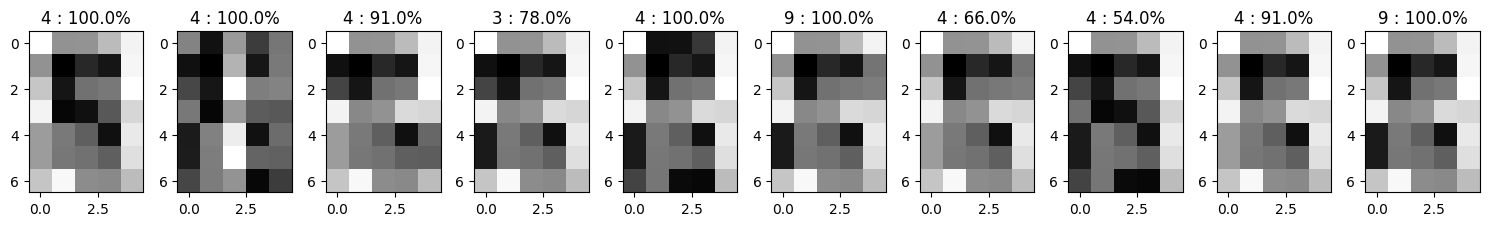

In [43]:
noise_size = 1.0
x_noised = nums_mtrx + np.random.uniform(0, noise_size, 35)

y_pred = list([model.predict(xi) for xi in x_noised])

fig, axes = plt.subplots(nrows=1, ncols=10)

fig.set_dpi(100)
fig.set_figwidth(15)
fig.set_figheight(5)

for i, ax in enumerate(axes.ravel()):
    ax.imshow(x_noised[i].reshape((7, 5)),  cmap='binary_r')
    j = np.argmax(y_pred[i])
    ax.set_title(f"{j} : {(y_pred[i][j] * 100).round()}%")

plt.tight_layout()
plt.show()

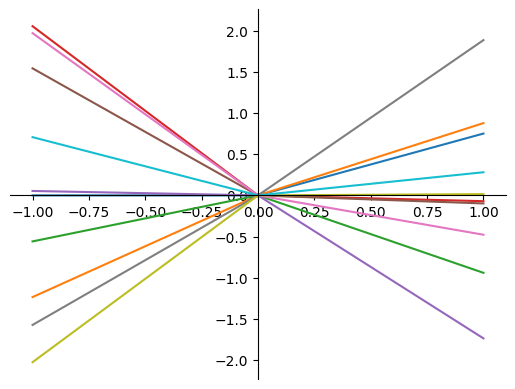

In [44]:
x = np.linspace(-1, 1, 100)

for p, q in zip(model.p, model.q):
    y = p * x * (x >= 0) + q * x * (x < 0)
    plt.plot(x, y)

ax = plt.gca()
ax.spines['top'].set_color('none')
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')

plt.show()